In [1]:
# general
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

# first used in exercise one
import coorddescent as cd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV

# first used in exercise two
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# first used in exercise three
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

# Exercise One

Note: I've submitted my implementation in the coorddescent.py file. I use this implementation in this notebook - I imported the module above and gave it the alias 'cp'. In addition, in case it helps understand how my implementation works, I've included the tests I wrote as part of doing the implementation. These are in the file coorddescent-test.py.

*"Write a function that computes the formula of the solution of this minimization problem."*

I did this in coorddescent.py, in the function minimize_beta_term (which calls the a_term and c_term functions). 

*"Write a function that computes the formula of the solution of this partial minimization problem with respect to βj for any j = 1,...,d."*

I did this in coorddescent.py, again in the function minimize_beta_term. 

*"Consider the Hitters dataset from [1]. Standardize the data, i.e., center the features and divide them by their standard deviation, and center the outputs."*

In [85]:
h = pd.read_csv('Hitters.csv', index_col=0)
h.shape

(322, 20)

In [86]:
h[:3]

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
Name,,,,,,,,,,,,,,,,,,,,
-Andy Allanson,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A


In [87]:
# remove rows w/ empty values - i think this is only those w/ no salary
h = h.dropna()
h.shape

(263, 20)

In [88]:
# convert categorical vars to dummy variables
h = pd.get_dummies(h)
h.shape

(263, 23)

In [89]:
h[:1]

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,PutOuts,Assists,Errors,Salary,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
Name,,,,,,,,,,,,,,,,,,,,,
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,...,632,43,10,475.0,0,1,0,1,0,1


While the homework doesn't state it specifically, I assume here that we're predicting salary, since that's what we've done previously.

In [145]:
# split into features and the value to predict (x and y)
# scale all features so each col has mean zero and std 1
X_scaled = preprocessing.scale(h.drop('Salary', axis=1))
y = preprocessing.scale(h['Salary'], with_mean=True, with_std=False) 
# only center y, per the instrs

(X_scaled.shape, y.shape)

((263, 22), (263,))

In [219]:
feature_count = X_scaled.shape[1]
feature_count

22

*"Write a function computeobj that computes and returns F(β) for any β."*

I did this in coorddescent.py, in the function lasso_objective.

*"Write a function cycliccoorddescent that implements the cyclic coordinate descent al- gorithm."*

I did this in coorddescent.py, in the function cycliccoorddescent. This function calls the function coorddescent, which handles the the main algorithm for both cyclic and random implementations - this function passes a sequential set of j values.

*"Write a function pickcoord that samples uniformly from the set {1, . . . , d} ."*

I implemented this functionality in the get_sequence_of_js function. This function returns a list of values that define the specific beta values/coefficients to be minimized. When called with the random parameter equal to False, the function returns a sequential list of j values (i.e., [1 2 3 1 2 3 ...]). When called with random equal to True, the function samples uniformly from the set {1,...,d} and returns a list of j values built from these random selections.

*"Write a function randcoorddescent that implements the randomized coordinate descent algorithm. "*

I did this in coorddescent.py, in the function randcoorddescent. This function calls the function coorddescent, which handles the the main algorithm for both cyclic and random implementations - this function passes a set of j values that have been randomly chosen.

*"Set the maximum number of iterations to 1000. In the remainder, the iteration counter iter refers here to t/d, that is the effective number of passes over all coordinates. Run cross-validation on the training set of the Hitters dataset using scikit-learn to find the optimal value of λ. Run cycliccoorddescent and randcoorddescent on the training set of the Hitters dataset for that value of λ found by cross-validation. Plot the curves of the objective values F(βt) for both algorithms versus the iteration counter iter (use different colors). What do you observe?"*

As shown below, and not surprisingly, the random implementation gets to smaller values of the objective function more quickly. Both the cyclic and random implementations get to roughly the same value by around 20 effective iterations (where one 'effective iteration' means an opportunity to update each coefficient one time - i.e., here, one effective iteration is 22 actual iterations, since there are 22 features).

The coefficients identified by both the cyclic and random approaches are similar, but not identical. The coefficients from my implementation aren't the same as the best coefficients from the canned LassoCV implementation - I spent significant time debugging to try to find the cause of these difference(s), but couldn't before I needed to turn this in. I notice that the canned implementation zeros out more coefficients with lambda values that I think - but am not sure - are equivalent, and as a result one of my first guesses if I had more time to spend on this would be that I'm not properly adjusting lambda between the canned code and my implementation. As a result the canned routine is actually penalizing coefficients more strongly than my code, with the same or close to the same lambda values, and as a result is zeroing out more coefficients.

In [151]:
lambda_vals = [10**k for k in range(-5, 5)]
# increasing max_iter from default of 1000 to ensure convergence (per
# a warning that I'll get when it's the default), also setting 
# normalize to False as we've already standardized the data (this
# may be ignored anyway, per the docs, as fit_intercept is also False)
lasso = LassoCV(alphas=lambda_vals, normalize=False, fit_intercept=False, max_iter=3000)

lasso.fit(X_scaled, y)
print('Estimated lambda =', lasso.alpha_)
print('Estimated coefficients =', lasso.coef_)
print('Estimated intercept =', lasso.intercept_)

Estimated lambda = 1.0
Estimated coefficients = [ -2.81117268e+02   3.03712775e+02   1.11305087e+01  -2.52375071e+01
  -0.00000000e+00   1.20835970e+02  -3.50432874e+01  -1.61321987e+02
   0.00000000e+00   1.42718229e+01   3.75151758e+02   1.92215411e+02
  -1.90239127e+02   7.86764498e+01   4.18852670e+01  -1.88344509e+01
  -2.32090081e+01   0.00000000e+00   5.82344284e+01  -1.09636474e-11
   4.94183895e+00  -0.00000000e+00]
Estimated intercept = 0.0


In [152]:
# per the discussion group, I think I understood that sklearn produces
# lambda estimates that are 1/2 of what our function uses, so I'll 
# scale up by two here
best_lam = lasso.alpha_ * 2
best_lam

2.0

In [220]:
# Corinne said that the statement in the homework to run it with 1000 iterations
# means to run it with 1000 effective iterations, so we need to scale up by
# the number of features
actual_iteration_count = 100 * feature_count
actual_iteration_count

2200

In [154]:
betas_cyclic = cd.cycliccoorddescent(X_scaled, y, best_lam, max_iter=actual_iteration_count)
cd.get_final_coefs(betas_cyclic)

array([ -3.38480647e+02,   3.28934898e+02,  -2.31399255e+00,
        -1.57352158e+01,   1.42496409e+01,   1.38767849e+02,
        -7.26775817e+01,  -7.61511602e+01,   3.23780937e+02,
         1.87053756e+02,   1.47100435e+02,  -9.82388336e+01,
        -2.01256803e+02,   8.07226588e+01,   4.93003836e+01,
        -2.48421388e+01,  -3.21876071e+01,   0.00000000e+00,
         6.14032727e+01,  -1.16604656e-12,   1.76341870e+01,
        -1.72907738e-15])

In [155]:
betas_random = cd.randcoorddescent(X_scaled, y, best_lam, max_iter=actual_iteration_count)
cd.get_final_coefs(betas_random)

array([-292.1389253 ,  298.61764833,   10.76322048,  -15.08862952,
         -2.31597639,  128.10363368,  -52.79645565, -189.65414231,
        239.23432488,   88.07744427,  218.60056076,   80.06025082,
       -179.63670635,   78.96718727,   49.28991304,  -24.98640479,
        -18.33864214,   13.42282201,   63.40255217,    2.1793557 ,
         24.08835787,    8.04490267])

In [156]:
obj_values = pd.DataFrame({
    'cyclic': betas_cyclic.apply(lambda r: cd.lasso_objective(r.as_matrix(), X_scaled, y, best_lam), axis=1),
    'random': betas_random.apply(lambda r: cd.lasso_objective(r.as_matrix(), X_scaled, y, best_lam), axis=1)
})
obj_values[:3]

,cyclic,random
0,202734.269158,202734.269158
1,171494.821398,202735.185257
2,170861.969141,202735.185257


In [221]:
def only_full_iterations(df):
    """Return a filtered dataframe with only rows for complete iterations."""
    return df[::feature_count].reset_index(drop=True)

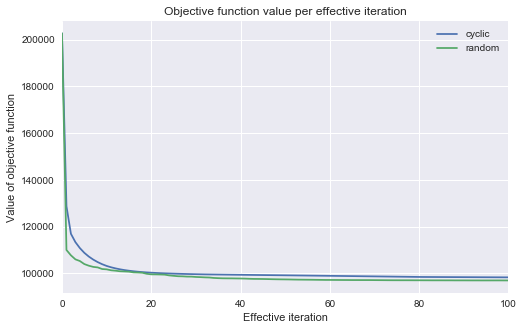

In [222]:
ax = only_full_iterations(obj_values).plot(title="Objective function value per effective iteration")
ax.set_xlabel("Effective iteration")
ax.set_ylabel("Value of objective function")

*"Denote by βT the final iterates of your coordinate descent algorithms for that value of λ. Compute β⋆ found by scikit-learn for that value of λ. Plot the curves of the fraction of correct non-zero coefficients (with respect to β⋆) for both algorithms versus the iteration counter iter (use different colors). What do you observe? Plot the curves of the fraction of correct zero coefficients for both algorithms (with respect to β⋆) versus the iteration counter iter (use different colors). What do you observe?"*

As shown below, my non-zero coefficients quickly converge to about 80% of the correct/sklearn solution. My zero coefficients never get this close: my routine's not zeroing out as many coefficients as the canned code. I commented on this above where I said that my first guess is that I'm not handling the lambda value so that it has the same effect in the canned routine and in my code. If that's not the cause of the problem, then there's likely something wrong with my implementation - I dug into this for some time and wasn't able to find places where I was doing something correctly.

In [183]:
zero_threshold = 1e-10 # treat anything within this as zero, FP rounding?
def count_of_matching_nonzeros(test_coefs, actual_coefs):
    return sum((abs(test_coefs) > zero_threshold) & (abs(actual_coefs) > zero_threshold))

def count_of_matching_zeros(test_coefs, actual_coefs):
    return sum((abs(test_coefs) <= zero_threshold) & (abs(actual_coefs) <= zero_threshold))

In [208]:
matching_nonzeros = pd.DataFrame({
    'cyclic': betas_cyclic.apply(lambda r: count_of_matching_nonzeros(r.as_matrix(), lasso.coef_), axis=1),
    'random': betas_random.apply(lambda r: count_of_matching_nonzeros(r.as_matrix(), lasso.coef_), axis=1)
})
matching_nonzeros[:3]

,cyclic,random
0,0,0
1,1,1
2,2,1


In [206]:
matching_zeros = pd.DataFrame({
    'cyclic': betas_cyclic.apply(lambda r: count_of_matching_zeros(r.as_matrix(), lasso.coef_), axis=1),
    'random': betas_random.apply(lambda r: count_of_matching_zeros(r.as_matrix(), lasso.coef_), axis=1)
})
matching_zeros[:3]

,cyclic,random
0,5,5
1,5,5
2,5,5


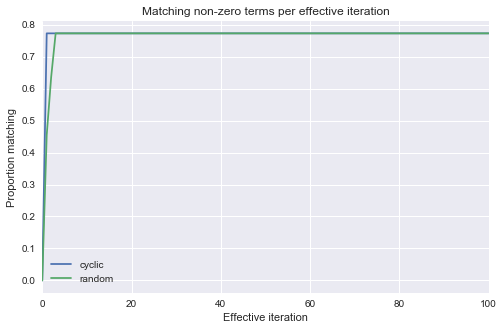

In [223]:
ax = (only_full_iterations(matching_nonzeros) / feature_count).plot(title="Matching non-zero terms per effective iteration")
ax.set_xlabel("Effective iteration")
ax.set_ylabel("Proportion matching")

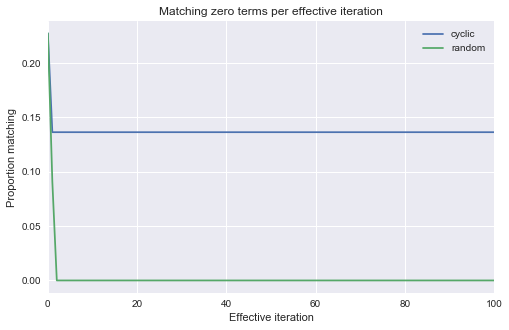

In [224]:
ax = (only_full_iterations(matching_zeros) / feature_count).plot(title="Matching zero terms per effective iteration")
ax.set_xlabel("Effective iteration")
ax.set_ylabel("Proportion matching")

# Exercise Two

*"a) Generate a simulated data set with 20 observations in each of three classes (i.e. 60 observations total), and 50 variables. Hint: There are a number of functions in numpy that you can use to generate data. One example is the numpy.random.normal() func- tion; numpy.random.uniform() is another option. Be sure to add a mean shift to the observations in each class so that there are three distinct classes."*

In [17]:
mean_vals = [0, 0.5, 1]
d = pd.DataFrame(np.vstack([np.random.normal(mean, size=(20,50)) for mean in mean_vals]))
d.insert(0, 'Class', np.repeat(['A','B','C'], 20))
d[:1]

,Class,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,A,0.546565,1.661999,-0.385265,-0.929298,0.973121,-0.084453,-0.395045,1.278515,1.04161,...,1.07968,-0.667667,1.125655,-0.579719,0.00175,-2.046451,-0.331116,-0.31251,-1.848161,-0.535899


*"b) Perform PCA on the 60 observations and plot the first two principal component score vectors. Use a different color to indicate the observations in each of the three classes. If the three classes appear separated in this plot, then continue on to part (c). If not, then return to part (a) and modify the simulation so that there is greater separation between the three classes. Do not continue to part (c) until the three classes show at least some separation in the first two principal component score vectors."*

As I haven't yet been able to get color output when exporting notebooks to PDFs, in addition to the color (that isn't visible in the PDF), I also made the different classes appear with different symbols: o, x, and +.

I could have made the classes farther apart by adjusting the mean values in the code immediately above, but I left them relatively close (but still apart) to learn more about how K-means would handle the data.

In [18]:
d_train_values = d.values[:, 1:51].astype('float')

pca = PCA(2, svd_solver='randomized')
pca.fit(d_train_values)
values_PCA = pca.transform(d_train_values)

In [19]:
pca.components_.shape, values_PCA.shape

((2, 50), (60, 2))

In [22]:
# add PCA values to the dataframe
d['PCA1'] = values_PCA[:, 0]
d['PCA2'] = values_PCA[:, 1]

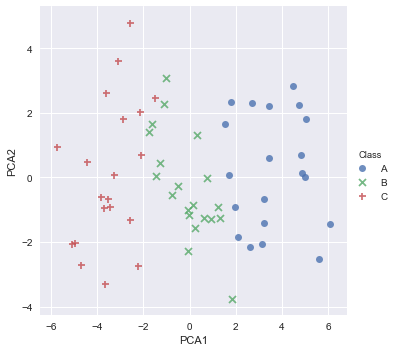

In [23]:
sns.lmplot("PCA1", "PCA2", hue="Class", markers=["o","x","+"], data=d, fit_reg=False)

*"c) Perform K-means clustering of the observations with K = 3. How well do the clusters that you obtained in K-means clustering compare to the true class labels? Hint: You can use the value counts() function in the pandas package in Python to compare the true class labels to the class labels obtained by clustering. Be careful how you interpret the results: K-means clustering will arbitrarily number the clusters, so you cannot simply check whether the true class labels and clustering labels are the same."*

As shown below, the clusters are more correct than not, but - because I made my data produce points in different classes that are quite close together - the clusters aren't perfect. 

In [24]:
def cluster_with_kmeans_and_plot(n_clusters, X, name):
    k = KMeans(n_clusters=n_clusters, random_state=0)
    k.fit(X)
    y_kmeans = k.predict(X)
    d[name] = y_kmeans
    sns.lmplot("PCA1", "PCA2", hue="Class", col=name, markers=["o","x","+"], data=d, fit_reg=False, col_wrap=2)

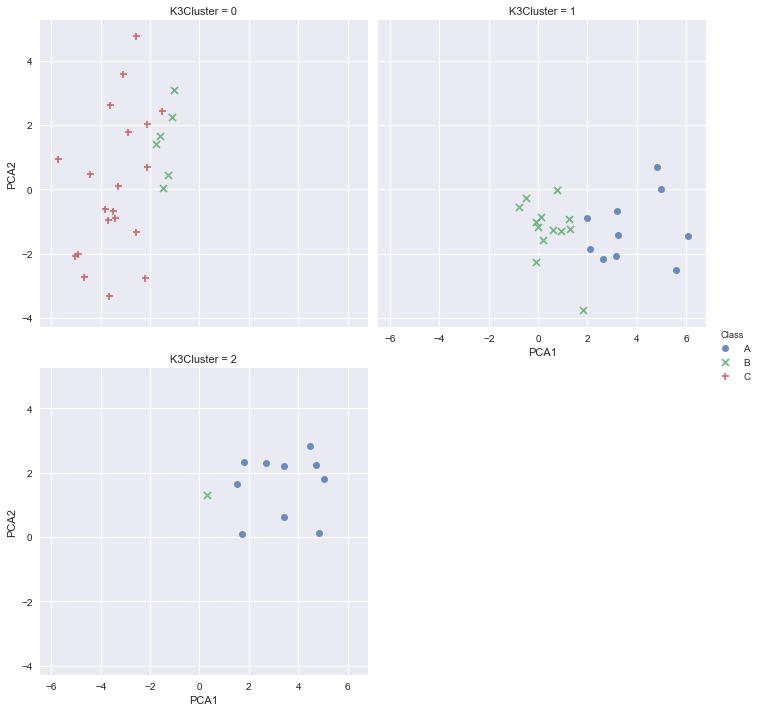

In [25]:
cluster_with_kmeans_and_plot(3, d_train_values, "K3Cluster")

*"d) Perform K-means clustering with K = 2. Describe your results."*

The results aren't as good with K=2, as expected, because there are actually three different classes and the algorithm isn't able to divide the points into just two classes. The algorithm DOES still divide two of the three classes well - it just doesn't handle the class 'in the middle'.

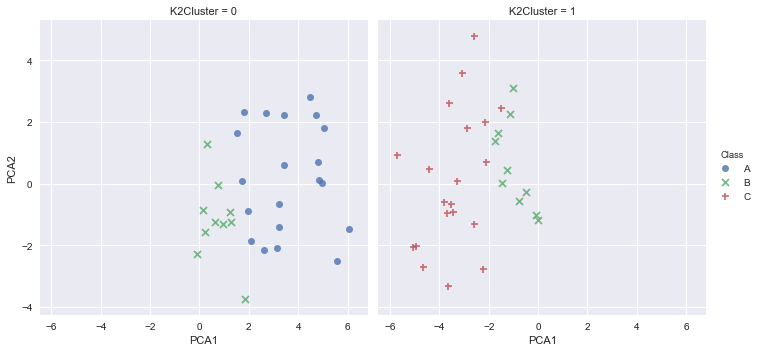

In [26]:
cluster_with_kmeans_and_plot(2, d_train_values, "K2Cluster")

*"e) Now perform K-means clustering with K = 4, and describe your results."*

Somewhat like with K=2, the algorithm does somewhat correctly identify two of the three classes, but has trouble with one class, putting it into three different clusters.

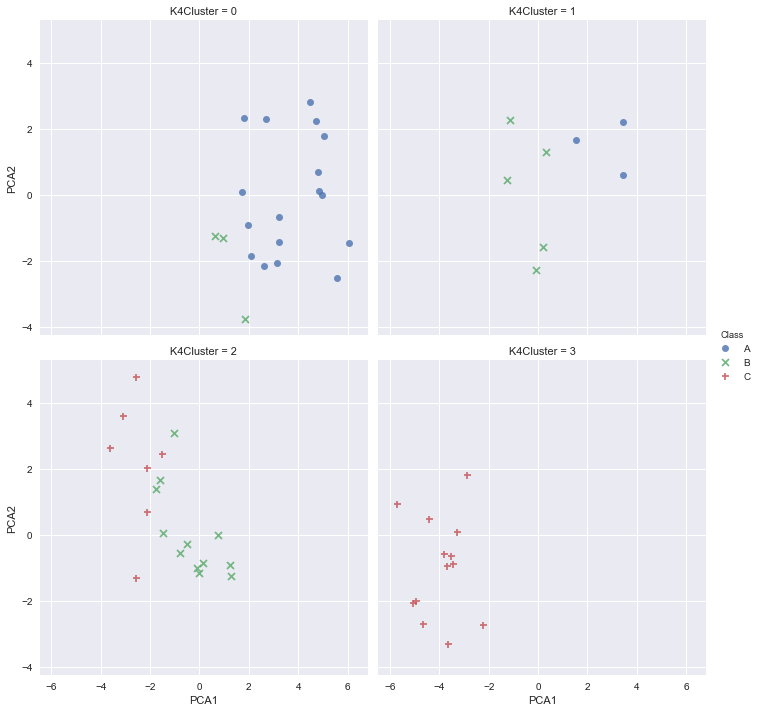

In [27]:
cluster_with_kmeans_and_plot(4, d_train_values, "K4Cluster")

*"f) Now perform K-means clustering with K = 3 on the first two principal component score vectors, rather than on the raw data. That is, perform K-means clustering on the 60 × 2 matrix of which the first column is the first principal component score vector, and the second column is the second principal component score vector. Comment on the results."*

I'm not 100% sure I understand what this question is asking, but based on conversations with other students I think what it's saying to do is to use the two values provided by PCA for each observation by feeding them to K-means, and then see what clusters those values provide. 

I already have the PCA results from transforming the data - a 60x2 matrix stored in values_PCA - and I used that data here. The results show that two of the three classes are handled well, but that one class is split close to evenly across two different clusters.

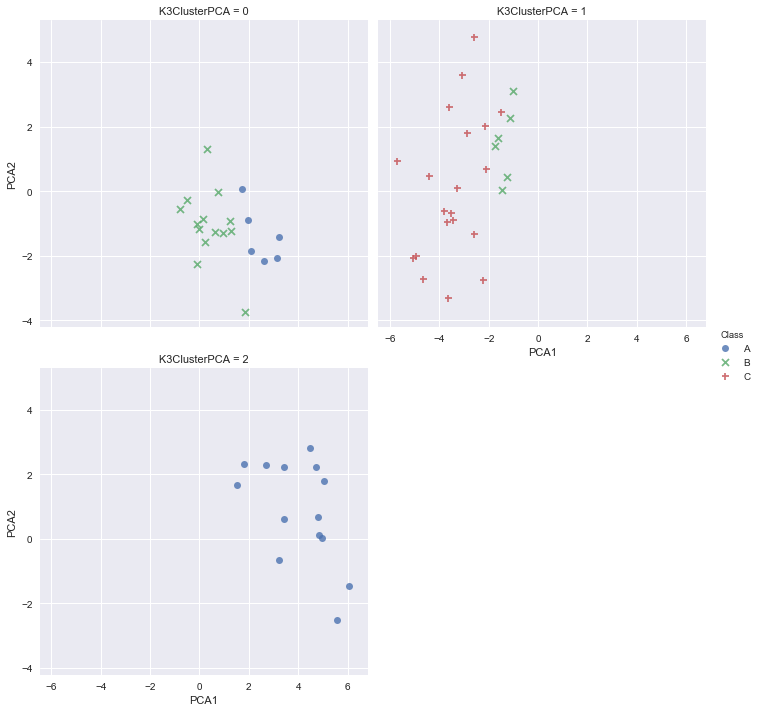

In [28]:
cluster_with_kmeans_and_plot(3, values_PCA, "K3ClusterPCA")

*"g) Use the StandardScaler function in sklearn.preprocessing to scale each variable to have standard deviation one. Then perform K-means clustering with K = 3 on the scaled data. How do these results compare to those obtained in (b)? Explain."*

Again I think because in my data the classes are relatively close together the algorithm doesn't do a perfect job of splitting the classes. In addition, while I expect each class to have a stddev of roughly one because that's how I generated the random data, it won't be exactly one just because of randomness. Nonetheless, I can see in the actual data that the existing stddevs _are_ already pretty close to one, so I don't expect to see much change when I standardize them to one. (Also, I think I'd choose to use the scale function instead of StandardScaler, myself, but I'll do this with StandardScaler since that's what the homework asks for.)

In [29]:
[np.std(d_train_values[:,i]) for i in range(0,50)][:5]

[1.2455790293380213,
 1.083511938063128,
 1.0416366966540009,
 1.2448136294103151,
 1.2747343551403407]

In [30]:
scaler = preprocessing.StandardScaler(with_mean=False, with_std=True).fit(d_train_values)
scaler

StandardScaler(copy=True, with_mean=False, with_std=True)

In [31]:
d_train_values_std = scaler.transform(d_train_values)
[np.std(d_train_values_std[:,i]) for i in range(0,50)][:5]

[1.0, 1.0, 1.0, 1.0, 0.99999999999999978]

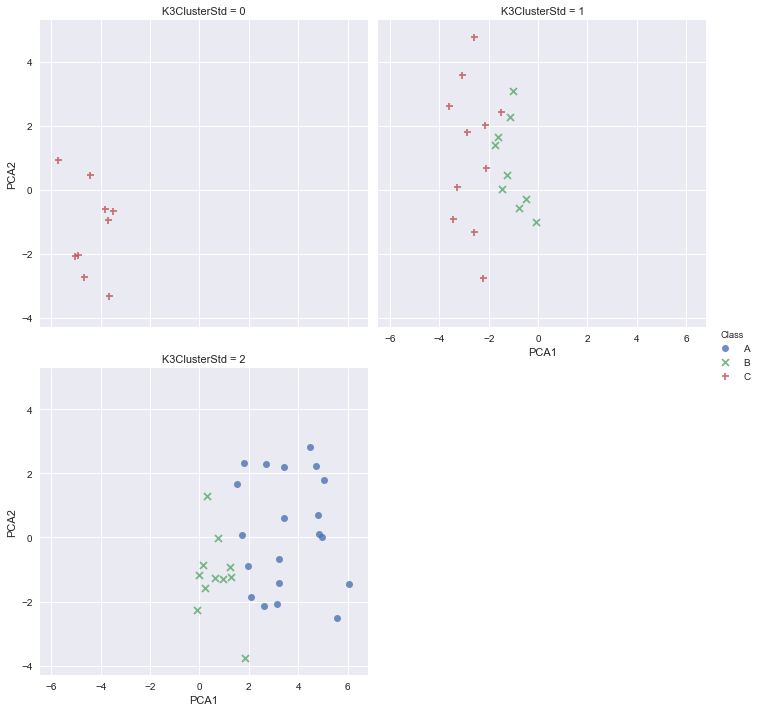

In [32]:
cluster_with_kmeans_and_plot(3, d_train_values_std, "K3ClusterStd")

# Exercise Three

*"a) Use the numpy.random.normal() function to generate a predictor X of length n = 100, as well as a noise vector ε of length n = 100."*

In [33]:
X = np.random.normal(size=100)
e = np.random.normal(size=100)
(X.shape, e.shape)

((100,), (100,))

*"b) Generate a response vector Y of length n = 100 according to the model Y =β0 +β1X+β2X2 +β3X3 +ε,
where β0, β1, β2, and β3 are constants of your choice. Here superscripts denote powers of X."*

I'm just choosing the coefficients.

In [34]:
b0 = 27
b1 = 11
b2 = 5
b3 = 3

In [35]:
y = b0 + (b1*X) + (b2*(X**2)) + (b3*(X**3)) + e
y.shape

(100,)

In [36]:
# and we'll make X a 100,1 array rather than a vector, for better use w/ sklearn functions
X = X[:, np.newaxis]
X.shape

(100, 1)

*"c) Now fit a lasso model to the simulated data, using X, X2, . . . , X10 as predictors. Use cross-validation to select the optimal value of λ. Create plots of the cross-validation error as a function of λ. Report the resulting coefficient estimates, and discuss the results obtained."*

The cross-validation error as a function of lambda is shown below, in addition to the y-intercept and coefficients chosen by the Lasso algorithm with the best value of lambda. It's cool to see that the Lasso algorithm correctly recovers both the y-intercept and the values of the three coefficients actually used to generate the data, AND that the algorithm zeroes out coefficients for higher order polynomials that weren't used when generating the data. Powerful stuff.

In [37]:
X_poly10 = PolynomialFeatures(degree=10).fit_transform(X)
X_poly10.shape

(100, 11)

In [38]:
lambda_vals

[1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

I think, based on the .score method, that the default evaluator for both Lasso and LassoCV is the R^2 (coefficient of determination) - if I pass in a "r2" value to the scoring param of cross_val_score, I get the same output as I do when I don't specify anything.

In [42]:
r2_by_lambda = pd.Series([np.mean(cross_val_score(Lasso(alpha=lam, 
                                  normalize=True,
                                  max_iter=1000000), X_poly10, y, cv=10, scoring="r2")) for lam in lambda_vals],
                         index = lambda_vals)
r2_by_lambda

0.00001        0.978673
0.00010        0.985025
0.00100        0.988917
0.01000        0.989658
0.10000        0.956480
1.00000        0.570619
10.00000      -0.081761
100.00000     -0.081761
1000.00000    -0.081761
10000.00000   -0.081761
dtype: float64

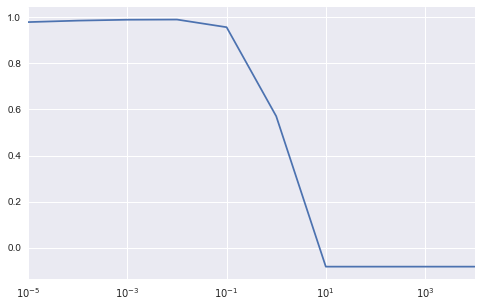

In [43]:
r2_by_lambda.plot(logx=True)

In [44]:
best_lambda = r2_by_lambda.argmax()
best_lambda

0.01

In [45]:
def fit_lasso_and_output_coefs_and_intercept(lam, X, y):
    results = Lasso(alpha=lam, normalize=True).fit(X, y)
    print(results.intercept_)
    display(list(zip(PolynomialFeatures(10).fit(X).get_feature_names(), results.coef_)))

In [46]:
fit_lasso_and_output_coefs_and_intercept(best_lambda, X_poly10, y)

27.0157463972


[('1', 0.0),
 ('x0', 10.915612748121022),
 ('x1', 4.834053762823439),
 ('x2', 2.94099579784789),
 ('x3', 0.0),
 ('x4', 0.0),
 ('x5', 0.0),
 ('x6', 0.0),
 ('x7', -0.0),
 ('x8', 0.0),
 ('x9', -0.0)]

*"d) Now generate a response vector Y according to the model Y = β0 + β7X7 + ε,
and fit a lasso model. Discuss the results obtained."*

Now the algorithm hasn't zeroed out the coefficients other than the beta7 coefficient. My guess is that there are multiple ways to use this many different polynomials to produce the value that comes from raising X to the seventh power and the model has chosen one of these other ways.

In [48]:
b7 = 12
new_y = b0 + (b7*(X[:,0]**7)) + e
new_y.shape

(100,)

In [49]:
fit_lasso_and_output_coefs_and_intercept(0.00001, X_poly10, new_y)

28.0078983925


[('1', 0.0),
 ('x0', 24.482699381215831),
 ('x1', -7.7432150130787454),
 ('x2', -57.880332735340382),
 ('x3', 7.296121362136776),
 ('x4', 34.550855255038989),
 ('x5', -1.6475385839116563),
 ('x6', 4.7569837433792408),
 ('x7', -0.0049737614857195333),
 ('x8', 0.49259525379107544),
 ('x9', 0.019218134501454123)]

# Exercise Four

This is ungraded exercise with specific suggested steps to work on as part of the Kaggle competition. I haven't yet started this as I've been focused on the homework after returning from my trip last week. I definitely won't wait too long to get started - I expect that it will be time-consuming and not amenable to doing it all last minute.

# Exercise Five

*"Is there a concept you would love to see covered during the course?"*

It seems like the syllabus is changing/has changed a bit, and I'm not sure what the overall plans are for coverage in the rest of the class. So I'll just jot down quick thoughts about things I'd like to know AND things that I at least have some clue about already but that others have said they want to learn about.

* On 4/26 you said that you view ridge, lasso, and logistic regression as the key/core pieces of ML. Can you explain more about why this is? Why are they so important in comparison to lots of other algorithms, for example? I only use ML sometimes in my day job, but when I do use ML I've spent a lot of time trying to understand things we haven't covered in class - for example, practicalities of feature engineering, different performance metrics, the nitty gritty of comparing different algorithms, and so on. For me at least I wonder if more coverage of some of these things that I've wrestled with myself could be more useful (at least immediately) than some of the detailed work and math that we've done.
* Specific algorithms: a) tree-based algorithms - likely in some detail, since they're used so heavily in a lot of places, b) SVMs, c) at least an intro to neural nets and deep learning. 
* That said, I think I'd benefit most from understanding roughly - but not in detail - how these work, how to use them (dials, levers), and pros and cons compared to other algorithms (these often work well with this kind of data, etc.). Mainly given the relatively short amount of time we have - only a single class, to cover all of 'machine learning' - I don't think I'd prefer to spend tons of time actually implementing particular algorithms. It's very interesting and I learn a lot by doing my own implementation, but probably get less practical benefit from time spent on implementation than I would get from a better overall understanding of the pros and cons of more algorithms. No?
* Feature engineering. I think we're covering this already for one kind of features, with the image work. But coverage of other kinds of features and transformations would be useful/helpful too. As a rough example of the kinds of things I'd like to learn more of: taking lat/lon and transforming into 'close to this kind of business', taking a single date field and generating 'IsHoliday', etc. From my understanding of Kaggle competitions and my experience at work, it sounds like feature engineering is usually more important for creating better models than the algorithm.
* More coverage of 'small data' uses of ML. At least for me at Microsoft, a lot of my work is with data sets that have an understandable number of features - for example, 20-30 instead of 1000s. More coverage of things to do with smaller numbers of features would be valuable to me. 

*"Is there a concept that has been used multiple times during the course, but you still have no idea what it means?"*

I'm still weak on interpreting mathemtical notation (I prefer words) and linear algebra, although am improving - enough to where I could figure out the coordinate descent stuff based just on a few slides w/ formulas. So I'm probably ok there.

*"Do you feel that you learn better when the course material is covered using slides, or tablet/whiteboard, or numerical illustrations?"*

I learn better when the explanations are in words instead of in mathematical notation, at least to start. As part of 'words' I include examples - i.e., rather than just 'here's the formula' I would learn better by seeing a worked example (or by working an example myself).